In [20]:
#nödvändiga imports för pytorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#för att arbeta med filer och mappar
import os

#för att manipulera bilderna
import cv2

#för att kunna visualisera bilder och grafer
from matplotlib import pyplot as plt

#för att arbeta med siffror
import numpy as np

#progressbar
from tqdm import tqdm


import pydicom as dicom


from random import randint

#används för att kontinuerligt kunna spara data och modeller.
import pickle

In [13]:
#paths till data som ligger på google drive
# train_anomaly = r'D:\ml gymarb\pnemoni\anomaly'
# train_normal = r'D:\ml gymarb\pnemoni\normal'

# val_anomaly = r'D:\ml gymarb\pnemoni\val_anomaly'
# val_normal = r'D:\ml gymarb\pnemoni\val_normal'


train_anomaly = r'D:\ml gymarb\crx\chest_xray\train\PNEUMONIA'
train_normal = r'D:\ml gymarb\crx\chest_xray\train\NORMAL'

val_anomaly = r'D:\ml gymarb\crx\chest_xray\test\PNEUMONIA'
val_normal = r'D:\ml gymarb\crx\chest_xray\test\NORMAL'






LABELS_train = {train_normal: 0, train_anomaly: 1}
classes = ('Normal', 'Anomaly')


#alla bilder standardiseras till denna storlek
img_size = 512





#det är viktigt att normal kommer för anomaly när du ger filpaths
class tbDataset(Dataset):
    def __init__(self, normal_path, anomaly_path, breakoff):
        self.samples = []
        self.image_folders = {normal_path: 0, anomaly_path: 1}


        for folder in self.image_folders:
            #print(folder)
 
            for image in tqdm(os.listdir(folder)):
            #for image in os.listdir(folder):
              #print(image)

            
              #if '.jpg' in image:
              path = folder + '/' + image

                  #öppnar bilden som svartvit
              img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

                  #ändrar storleken på bilden till img_size
              img = cv2.resize(img, (img_size, img_size))

                  #lägger till bilderna (som numpy arrays) samt en label i samples
              self.samples.append((np.array(img), self.image_folders[folder]))


              #begränsar till en viss mängd bilder totalt.
              if folder == train_normal or folder == val_normal:
                if len(self.samples) >= breakoff:
                  break
              if folder == train_anomaly or folder == val_anomaly:
                if len(self.samples) >= (breakoff*2):
                  break


        #räknar antal förekomster av normal och anomaly
        normal_count = 0
        anomaly_count = 0
        for sample in self.samples:      
          if sample[1] == 0:
            normal_count += 1
          elif sample[1] == 1:
            anomaly_count += 1
        print('')
        print('no of normal: ', normal_count)
        print('no of anomaly: ', anomaly_count)
        print('')
        


    def __len__(self):
        return len(self.samples)
 
    def __getitem__(self, idx):
        return(self.samples[idx])
 
tSet = tbDataset(train_normal, train_anomaly, 1300)
vSet = tbDataset(val_normal, val_anomaly, 230)

print('')
print('length of trainset: ', len(tSet))
print('length of validationset: ', len(vSet))



 33%|███▎      | 1299/3883 [00:26<00:51, 49.92it/s]



no of normal:  1300
no of anomaly:  1300



 59%|█████▊    | 229/390 [00:02<00:01, 107.21it/s]


no of normal:  230
no of anomaly:  230


length of trainset:  2600
length of validationset:  460


In [14]:
batchSize = 64


#skapar dataloaders
trainLoader = DataLoader(tSet, batch_size=batchSize, shuffle=True, drop_last=True)
valLoader = DataLoader(vSet, batch_size=batchSize, shuffle=True, drop_last=True)

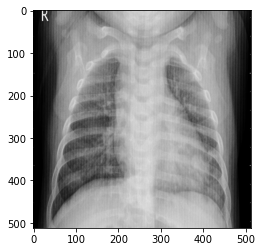

Anomaly


In [15]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainLoader)
images, labels = dataiter.next()

# show image
imshow(torchvision.utils.make_grid(images[0]))
# print label
#print(labels[0])
print(classes[labels[0]])

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
 
        #definierar mina convolutional layers
        # self.conv1 = nn.Conv2d(1, 32, 5)
        # self.conv2 = nn.Conv2d(32, 64, 5)

        # self.conv3 = nn.Conv2d(64, 128, 3)
 
        # self.pool = nn.MaxPool2d(2, 2)
 
        #vet inte hur man vet output från sista conv layer så måste mata fakedata genom
        #modellen
        # x = torch.randn(img_size,img_size).view(-1,1,img_size,img_size)
        # self._to_linear = None
        # self.convs(x)
 

        #här är mina linjära lager
        #self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc1 = nn.Linear(img_size*img_size, 1024)


        self.fc2 = nn.Linear(1024, 1024)

        self.fc3 = nn.Linear(1024, 512)

        self.fc4 = nn.Linear(512, 256)

        self.fc5 = nn.Linear(256, 2)
 
 
 
    def convs(self, x):
        # max pooling over 2x2
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = self.pool(F.relu(self.conv3(x)))

        
        if self._to_linear is None:
            #multiplicera varje dimension av x
            #(detta nummer kommer vara samma varje gång, så du behöver bara göra detta 1 gång)
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
 
 
    #detta bestämmer hur datan kommer att flöda genom modellen
    def forward(self, x):
        #går igenom alla convolutional layers och använder max pooling
        # x = self.convs(x)
        
        #flatten (convolutional layers kan ta emot multidimensionell data men linjära layers kan inte det)
        x = torch.flatten(x, 1) #flatten all dimensions except batch
 
        #använder en relu för första linjära lagret
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

 
        #kanske ska prova att använda softmax. 
        x = self.fc5(x)
 
        return x
 
 
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=262144, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=2, bias=True)
)


In [17]:
epochs = 15
resumePrev = False


#skapar nya värden
if resumePrev == False:
  bestAcc = 0.0 
  model = Net()
  accHistory = []

#laddar tidigare värden
else:
  with open('bestAcc.txt') as f:
    w = [float(x) for x in next(f).split()] # read first line
    bestAcc = w[0]
    with open ('accHist', 'rb') as fp:
      accHistory = pickle.load(fp)


  model = Net()
  model.load_state_dict(torch.load('best.pth'))


optimizer = optim.Adam(model.parameters(), lr=0.005)

#jag använder sgd eftersom den är mer basic att förklara i mitt gymnasiearbete 
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


for epoch in range(epochs):
    for data in tqdm(trainLoader):
 
        #detta är min data (kommer förmodligen se annorlunda ut med riktig data)
        inputs, labels = data
        inputs = inputs.view(batchSize, 1, img_size, img_size).float()

        #flyttar till gpu (om du har mycket data kommer allt inte få plats på din gpu
        # samtidigt (lös det då))
        #inputs, labels = inputs.to(gpu), labels.to(gpu)
 
        #nollställer gradien
        optimizer.zero_grad()
 
        #plattar till bilden och kör den genom modellen
        #output = model(inputs.view(-1, 1, img_size, img_size))
        #output = model(inputs.view(-1, img_size*img_size))
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        #beräknar loss (din output jämfört med din label)
        loss = criterion(outputs, labels)
 
        #we calculate the gradients, and then we step down the slope
        loss.backward()
        optimizer.step()
        

    #räknar validation varje epok (beöver egentligen bara göras i slutet av en träning)
    correct = 0
    total = 0
    count = 0
 
    with torch.no_grad():
        for data in valLoader:

            #i den över heter det inputs istället (gör detta konsekvent)
            images, labels = data
            images = images.view(batchSize, 1, img_size, img_size).float()
            #images, labels = images.to(gpu), labels.to(gpu)
            
            # calculate outputs by running images through the network
            outputs = model(images)
            #outputs = model(inputs.view(-1, 1, img_size, img_size))
            #output = model(inputs.view(-1, img_size*img_size))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            count += 1

    accHistory.append(100 * (correct / total))
    #sparar accHistory till fil
    with open('accHist', 'wb') as fp:
      pickle.dump(accHistory, fp)

    #spara modellen efter varje epok, sparar de bästa vikterna till fil.
    torch.save(model.state_dict(), 'latest.pth')
    if (correct / total) > bestAcc:
      bestAcc = (correct / total)
      f = open("bestAcc.txt", "w")
      f.write(str(bestAcc))
      f.close()
      torch.save(model.state_dict(), 'best.pth')
 

    
    print((epoch+1), '. Accuracy of the network: %d %%' % (100 * correct / total))
    print('')
print('training complete')

100%|██████████| 40/40 [04:03<00:00,  6.09s/it]


1 . Accuracy of the network: 50 %



100%|██████████| 40/40 [03:54<00:00,  5.86s/it]


2 . Accuracy of the network: 78 %



100%|██████████| 40/40 [03:53<00:00,  5.83s/it]


3 . Accuracy of the network: 83 %



100%|██████████| 40/40 [03:49<00:00,  5.74s/it]


4 . Accuracy of the network: 65 %



100%|██████████| 40/40 [03:47<00:00,  5.68s/it]


5 . Accuracy of the network: 78 %



100%|██████████| 40/40 [03:41<00:00,  5.54s/it]


6 . Accuracy of the network: 76 %



100%|██████████| 40/40 [03:43<00:00,  5.58s/it]


7 . Accuracy of the network: 50 %



100%|██████████| 40/40 [03:41<00:00,  5.53s/it]


8 . Accuracy of the network: 74 %



100%|██████████| 40/40 [03:41<00:00,  5.54s/it]


9 . Accuracy of the network: 82 %



100%|██████████| 40/40 [03:46<00:00,  5.66s/it]


10 . Accuracy of the network: 79 %



100%|██████████| 40/40 [03:50<00:00,  5.76s/it]


11 . Accuracy of the network: 79 %



100%|██████████| 40/40 [03:49<00:00,  5.74s/it]


12 . Accuracy of the network: 78 %



100%|██████████| 40/40 [03:39<00:00,  5.48s/it]


13 . Accuracy of the network: 72 %



100%|██████████| 40/40 [03:33<00:00,  5.33s/it]


14 . Accuracy of the network: 71 %



100%|██████████| 40/40 [03:39<00:00,  5.49s/it]


15 . Accuracy of the network: 61 %

training complete


aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

[50.0, 78.125, 83.25892857142857, 65.625, 78.34821428571429, 76.11607142857143, 50.22321428571429, 74.55357142857143, 82.58928571428571, 79.01785714285714, 79.46428571428571, 78.34821428571429, 72.76785714285714, 71.42857142857143, 61.16071428571429]


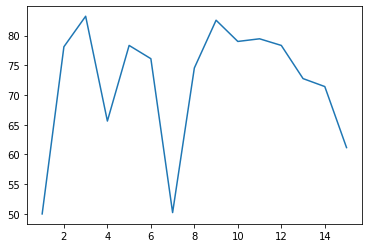

In [18]:
with open ('accHist', 'rb') as fp:
      accHistory = pickle.load(fp)

# print(accHistory)

print(accHistory)



xpoints = []
for i in range(15):
  xpoints.append(i + 1)

plt.plot(xpoints, accHistory)
plt.show()